> This file is the webpage available [here](https://mia_jinns.gitlab.io/jinns/Notebooks/ODE/1D_Generalized_Lotka_Volterra.html#Learning-the-neural-network-parameters). We added some comments to facilitate the comprehension.

# Generalized Lotka Volterra

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$$

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Float64 and GPU settings

In [41]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [42]:
import jinns

Import other dependencies

In [43]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx # doc here: https://docs.kidger.site/equinox/

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [44]:
eqx_list = [
    [eqx.nn.Linear, 1, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "ODE") # see here: https://mia_jinns.gitlab.io/jinns/utils.html#jinns.utils.create_PINN



In [45]:
init_nn_params = u.init_params()
print(type(init_nn_params))
print(init_nn_params.layers[3:5])

<class 'jinns.utils._pinn._MLP'>
[None, Linear(
  weight=f32[20,20],
  bias=f32[20],
  in_features=20,
  out_features=20,
  use_bias=True
)]


In the source code of the class PINN [here](https://mia_jinns.gitlab.io/jinns/_modules/jinns/utils/_pinn.html#create_PINN) we can see: 
<pre>
def init_params(self):
    return self.params
</pre>

And `self.params` is the first argument of `eqx.partition(_pinn, eqx.is_inexact_array)`. \
See [here](https://docs.kidger.site/equinox/api/manipulation/#equinox.is_inexact_array_like) for `eqx.is_inexact_array`.

Create a DataGenerator object

In [97]:
n = 320 # total number of points
batch_size = 32
method = 'uniform' # points will be uniformely sampled in the domain
tmin = 0 # time domain
tmax = 1 # time domain

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE( # https://mia_jinns.gitlab.io/jinns/data.html#jinns.data.DataGeneratorODE
    subkey,
    n,
    tmin,
    tmax,
    batch_size,                    
    method=method
)

print(dir(train_data))
print(train_data.curr_time_idx)
print(train_data.data_exists)
print(len(train_data.times))
print(train_data.times)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_key', 'curr_time_idx', 'data_exists', 'generate_time_data', 'get_batch', 'method', 'nt', 'nt_start', 'p', 'rar_iter_from_last_sampling', 'rar_iter_nb', 'rar_parameters', 'sample_in_time_domain', 'temporal_batch', 'temporal_batch_size', 'times', 'tmax', 'tmin', 'tree_flatten', 'tree_unflatten']
0
False
320
[0.6648468  0.71021736 0.5241176  0.4130417  0.99056923 0.7872757
 0.48394847 0.42396688 0.63643086 0.6767349  0.51280653 0.24819016
 0.36400974 0.47411227 0.6791841  0.91711247 0.01565671 0.319656
 0.67357016 0.7028494  0.798928   0.83178186 0.66278136 0.9442104
 0.39230204 0.8741088  0.06018806 0.38957798 0.41099215 0.32104862
 0.87477577 0.4

Initialize 3 set of neural network parameters for the 3 populations

In [50]:
init_nn_params_list = []
for _ in range(3):
    key, subkey = random.split(key)
    u = jinns.utils.create_PINN(subkey, eqx_list, "ODE", 0)
    init_nn_params = u.init_params()
    init_nn_params_list.append(init_nn_params)
print(init_nn_params_list[0].layers[3:5])

[None, Linear(
  weight=f32[20,20],
  bias=f32[20],
  in_features=20,
  out_features=20,
  use_bias=True
)]


Visualize the output of the neural networks before the parameter learning step

In [48]:
vectorized_u_init = vmap(lambda t: u(t, init_nn_params_list[0]), (0), 0)
vectorized_v_init = vmap(lambda t: u(t, init_nn_params_list[1]), (0), 0)
vectorized_w_init = vmap(lambda t: u(t, init_nn_params_list[2]), (0), 0)

plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_u_init(train_data.times.sort(axis=0)), label="N1")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_v_init(train_data.times.sort(axis=0)), label="N2")
plt.plot(train_data.times.sort(axis=0) * Tmax, vectorized_w_init(train_data.times.sort(axis=0)), label="N3")

plt.legend();

## Model parameters

Model presented above: 
$
\frac{\partial}{\partial t}u_i(t) = r_iu_i(t) - \sum_{j\neq i}\alpha_{ij}u_j(t)
-\alpha_{i,i}u_i(t) + c_iu_i(t) + \sum_{j \neq i} c_ju_j(t), i\in\{1, 2, 3\}
$

<span style="color:tomato"> <b> Isn't it: </b>
$
\frac{\partial}{\partial t}u_i(t) = 
r_iu_i(t) + u_i(t) \sum_{j\neq i}\alpha_{i,j}u_j(t) - \frac{r_i}{K_i} (u_i(t))^2
, i\in\{1, 2, 3\} \text{ and we have } \forall i, \alpha_{i,i} = 0
$  <b> ? </b>
 </span>

In [49]:
# initial conditions for each species
N_0 = jnp.array([10., 7., 4.]) # u_i(0)
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8]) # r_i
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02]) # K_i
# interactions
# NOTE that for the interaction between the species **with itself** is always at position 0
# NOTE minus sign 
interactions = -jnp.array([[0, 0.001, 0.001], [0, 0.001, 0.001], [0, 0.001, 0.001]]) # alpha_ij

## Loss construction

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary.

__Note__ that `nn_params` and `eq_params` must always be top level keys but can be nested dictionaries.

__Note__ that the keys of the sub dictionaries `nn_params` and `eq_params` (here `str(i)`) can differ !

In [53]:
# initiate parameters dictionary
init_params = {}

init_params["nn_params"] = {
    str(i): init_nn_params_list[i]
    for i in range(3)
}
print(init_params["nn_params"]["0"].layers[3:5])

init_params["eq_params"] = {
    str(i):{
        "carrying_capacity": carrying_capacities[i],
        "growth_rate": growth_rates[i],
        "interactions": interactions[i, :]
    }
    for i in range(3)
}
print(init_params["eq_params"]["0"])


[None, Linear(
  weight=f32[20,20],
  bias=f32[20],
  in_features=20,
  out_features=20,
  use_bias=True
)]
{'carrying_capacity': Array(0.04, dtype=float32), 'growth_rate': Array(0.1, dtype=float32), 'interactions': Array([-0.   , -0.001, -0.001], dtype=float32)}


We construct a SystemLossODE with GeneralizedLotkaVolterra losses for each population. Here `key_main` refer to the key in `params["nn_params"]` which are the parameters for the main PINN of the equation (the PINN which represents the solution differentiated with respect to the `t`). `key_others` refer to the keys in `params["nn_params"]` which are the parameters for the PINNs which interact with `key_main`.

In [54]:
N1_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="0", keys_other=["1", "2"], Tmax=Tmax)
N2_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="1", keys_other=["0", "2"], Tmax=Tmax)
N3_dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(key_main="2", keys_other=["0", "1"], Tmax=Tmax)
# See here: https://mia_jinns.gitlab.io/jinns/dynamic_loss.html#jinns.loss._DynamicLoss.GeneralizedLotkaVolterra

In [36]:
loss_weights = {"dyn_loss":1, "initial_condition":1 * Tmax}

loss = jinns.loss.SystemLossODE( # https://mia_jinns.gitlab.io/jinns/loss_ode.html#jinns.loss._LossODE.SystemLossODE
    u_dict={"0":u, "1":u, "2":u}, # same PINN but the parameters will be different
    loss_weights=loss_weights,
    dynamic_loss_dict={"0": N1_dynamic_loss, "1":N2_dynamic_loss, "2":N3_dynamic_loss},
    initial_condition_dict={"0":(float(tmin), N_0[0]), "1":(float(tmin), N_0[1]), "2":(float(tmin), N_0[2])}
)

In [74]:
"""
- jax.value_and_grad : 
    Create a function that evaluates both fun and the gradient of fun. 
    see https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html
- .evaluate : 
    Evaluate the dynamic loss at t. (For stability we implement the dynamic loss in log space.)
    see https://mia_jinns.gitlab.io/jinns/dynamic_loss.html#jinns.loss._DynamicLoss.GeneralizedLotkaVolterra.evaluate
    Parameters:
        > t is a time point
        > u_dict is a dictionary of PINNS. Must have the same keys as params_dict
        > params_dict is the dictionary of dictionaries of parameters of the model. Keys at top level are “nn_params” and “eq_params”
"""
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True) 

print(init_params.keys())
print(train_data.get_batch())
print(batch_size, train_data.get_batch()[0].shape)

losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)

l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }") # d

dict_keys(['nn_params', 'eq_params'])
ODEBatch(temporal_batch=Array([0.5261632 , 0.82636106, 0.60209715, 0.80010533, 0.7513592 ,
       0.45174265, 0.864804  , 0.55682373, 0.71371174, 0.6110482 ,
       0.53657806, 0.7800437 , 0.1559056 , 0.2318803 , 0.8194457 ,
       0.535238  , 0.18999481, 0.93670106, 0.27080595, 0.07142472,
       0.9422693 , 0.7164055 , 0.09310341, 0.00542307, 0.6937473 ,
       0.984388  , 0.8194579 , 0.3000939 , 0.10905313, 0.15348125,
       0.8986465 , 0.6825664 ], dtype=float32), param_batch_dict=None)
32 (32,)
total loss: 4428.27001953125
Individual losses: {'dyn_loss': '668.63', 'initial_condition': '3759.64', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [75]:
params = init_params

In [76]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)

In [77]:
n_iter = int(50000)

In [78]:
key, subkey = random.split(key)

In [79]:
"""
jinns.solver._solve.solve : Performs the optimization process via stochastic gradient descent algorithm. 
We minimize the function defined loss.evaluate() with respect to the learnable parameters of the problem 
whose initial values are given in init_params.
See : https://mia_jinns.gitlab.io/jinns/solve.html#jinns.solver._solve.solve
"""
params, total_loss_list, loss_by_term_dict, data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Iteration 0: loss value = 4395.3544921875


  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 1000: loss value = 288.2920227050781
Iteration 2000: loss value = 229.80593872070312
Iteration 3000: loss value = 140.8726806640625
Iteration 4000: loss value = 90.82415771484375
Iteration 5000: loss value = 56.62049102783203
Iteration 6000: loss value = 39.81999206542969
Iteration 7000: loss value = 29.545114517211914
Iteration 8000: loss value = 22.408721923828125
Iteration 9000: loss value = 14.107283592224121
Iteration 10000: loss value = 13.799966812133789
Iteration 11000: loss value = 8.903841972351074
Iteration 12000: loss value = 6.452279567718506
Iteration 13000: loss value = 4.803593635559082
Iteration 14000: loss value = 3.6471221446990967
Iteration 15000: loss value = 2.5812184810638428
Iteration 16000: loss value = 2.261322498321533
Iteration 17000: loss value = 1.391994833946228
Iteration 18000: loss value = 1.1745707988739014
Iteration 19000: loss value = 1.2429865598678589
Iteration 20000: loss value = 1.0601651668548584
Iteration 21000: loss value = 1.2991552

In [80]:
total_loss_list[-1]

Array(0.03926664, dtype=float32)

## Results

Plot the loss values

In [87]:
for loss_name, loss_values in loss_by_term_dict.items():
    if loss_name in ["observations", "dyn_loss"]:
        plt.plot(jnp.log10(loss_values), label=loss_name)
plt.legend()
plt.show();

for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

In [88]:
u_est_fp = vmap(lambda t:u(t, params["nn_params"]["0"]), (0), 0)
v_est_fp = vmap(lambda t:u(t, params["nn_params"]["1"]), (0), 0)
w_est_fp = vmap(lambda t:u(t, params["nn_params"]["2"]), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(subkey, n, tmin, tmax, batch_size, method)

plt.plot(val_data.times.sort(axis=0) * Tmax, u_est_fp(val_data.times.sort(axis=0)), label="N1")
plt.plot(val_data.times.sort(axis=0) * Tmax, v_est_fp(val_data.times.sort(axis=0)), label="N2")
plt.plot(val_data.times.sort(axis=0) * Tmax, w_est_fp(val_data.times.sort(axis=0)), label="N3")

plt.legend()

## Compare with the scipy solver
Code from Lorenzo Sala

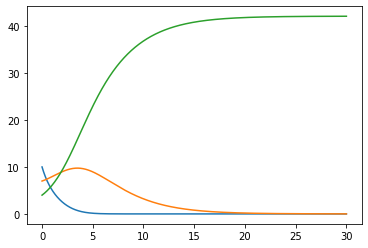

In [89]:
import numpy as np
from scipy.integrate import odeint

def lotka_volterra_log(y_log, t, params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.
    
    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.
        
    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)
    
    for i in range(N):
        dydt[i] = y[i] * (alpha[i] - beta[i] * np.sum(y) - np.sum([gamma[j][i] * y[j] for j in range(N)]))
    
    dydt_log = dydt / y
    
    return dydt_log

# Define name bacteria
names = ['N1', 'N2', 'N3']
N = len(names)

# Define model parameters
death_rates = None
params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4] #[0.26, 0.37, 0.57] #

# Define time points
Tmax = 30
t = np.linspace(0, Tmax, 1000)

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(params,))
y = np.exp(y_log)

for i in range(N): 
    plt.plot(t, y[:,i], label=names[i])